<a href="https://colab.research.google.com/github/atharva-ketkar1/DemographicPredictor/blob/main/demographics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import keras.backend as K
from itertools import product
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.losses import mean_absolute_error, binary_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/Demographic Predictor Files/UTKFace.zip';

Streaming output truncated to the last 5000 lines.
  inflating: UTKFace/30_1_0_20170117143902329.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._30_1_0_20170117143902329.jpg.chip.jpg  
  inflating: UTKFace/41_0_0_20170116214404363.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._41_0_0_20170116214404363.jpg.chip.jpg  
  inflating: UTKFace/58_0_1_20170113193258196.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._58_0_1_20170113193258196.jpg.chip.jpg  
  inflating: UTKFace/36_1_1_20170116155035948.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._36_1_1_20170116155035948.jpg.chip.jpg  
  inflating: UTKFace/25_0_0_20170113181532013.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._25_0_0_20170113181532013.jpg.chip.jpg  
  inflating: UTKFace/66_1_0_20170110123144558.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._66_1_0_20170110123144558.jpg.chip.jpg  
  inflating: UTKFace/40_0_1_20170117134411786.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._40_0_1_20170117134411786.jpg.chip.jpg  
  inflating: UTKFa

In [4]:
#path = '/content/drive/MyDrive/Demographic Predictor Files/UTKFace'
path = 'UTKFace'
age_labels = []
gender_labels = []
race_labels = []
image_paths = []

images = os.listdir(path)
random.shuffle(images)

for image in images:
  split = image.split("_")
  if len(split) < 4:
    continue
  image_path = os.path.join(path,image)
  age_label = int(split[0])
  gender_label = int(split[1])
  race_label = int(split[2])

  image_paths.append(image_path)
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  race_labels.append(race_label)

In [5]:
print(f'Age Number: {len(age_labels)}, Gender Number: {len(gender_labels)}, Race Number: {len(race_labels)}, Image_Paths: {len(image_paths)}')

Age Number: 23705, Gender Number: 23705, Race Number: 23705, Image_Paths: 23705


In [6]:
df = pd.DataFrame()
df['image_paths'], df['age'], df['gender'], df['race'] = image_paths, age_labels, gender_labels, race_labels

In [7]:
y_age = np.array(df['age'])
y_gender = np.array(df['gender'])
y_race = np.array(df['race'])

# Data Preprocessing

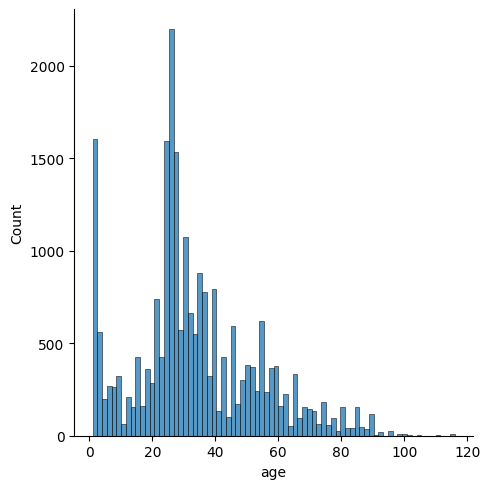

In [8]:
sns.displot(df['age'])

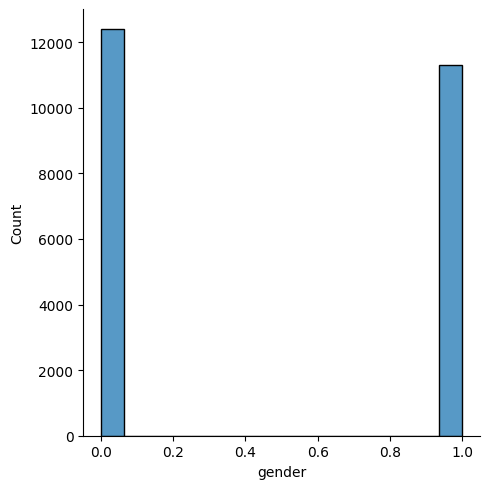

In [9]:
#[gender] is either 0 (male) or 1 (female)
sns.displot(df['gender'])

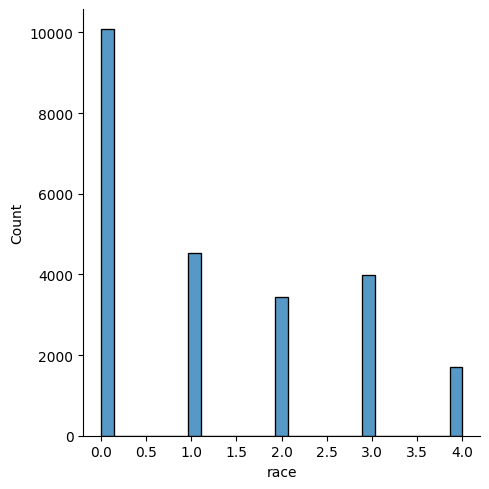

In [10]:
#[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
sns.displot(df['race'])

##### Age is pretty right skewed, gender has more women than men, and race is very imbalanced. Will have to take this into account. I will try to formulate class weights to help with this class imbalance

# Formulating Custom Class Weights and Loss Functions

In [11]:
age_counts = df['age'].value_counts()
gender_counts = df['gender'].value_counts()
race_counts = df['race'].value_counts()

In [12]:
def compute_class_weights(class_counts, column_name):
    class_labels = sorted(class_counts.index)
    classes = np.unique(df[column_name])
    class_weights = compute_class_weight('balanced', classes=classes, y=df[column_name])
    return {cls: weight for cls, weight in zip(class_labels, class_weights)}

# Pass the column name to the function
age_class_weights = compute_class_weights(age_counts, 'age')
gender_class_weights = compute_class_weights(gender_counts, 'gender')
race_class_weights = compute_class_weights(race_counts, 'race')

In [13]:
def normalize_class_weights(class_weights):
    total = sum(class_weights.values())
    return {cls: weight / total for cls, weight in class_weights.items()}

age_class_weights = normalize_class_weights(age_class_weights)
gender_class_weights = normalize_class_weights(gender_class_weights)
race_class_weights = normalize_class_weights(race_class_weights)

print("Age Class Weights:", age_class_weights)
print("Gender Class Weights:", gender_class_weights)
print("Race Class Weights:", race_class_weights)

Age Class Weights: {1: 0.00015879687600146158, 2: 0.0003699769538374302, 3: 0.0006170549887530843, 4: 0.00065321938369832, 5: 0.0009098412844369458, 6: 0.0013612892499972624, 7: 0.001282941667263607, 8: 0.0006780566226222105, 9: 0.0010742704322267553, 10: 0.00114313392147206, 11: 0.002743521411532944, 12: 0.001371760705766472, 13: 0.0022015912561684117, 14: 0.0011358528136919833, 15: 0.001007507862992324, 16: 0.000721979318824459, 17: 0.0011286638718331732, 18: 0.0006806446249986312, 19: 0.0018196825688738916, 20: 0.0006279186329212723, 21: 0.000515401421241738, 22: 0.00045146554873326923, 23: 0.0004186124219475149, 24: 0.00020760057246756853, 25: 0.00024295489339188196, 26: 8.116927253056048e-05, 27: 0.0002899656776416933, 28: 0.00019425805201485986, 29: 0.0003128577048239322, 30: 0.00024631062396359305, 31: 0.0005095111192846896, 32: 0.0002685676080566888, 33: 0.0012470551870604292, 34: 0.0004360119602680718, 35: 0.00020264646789731972, 36: 0.00036921095600339827, 37: 0.0006086310298

In [14]:
# Make these lists because tensorflow doesn't take dictionary input
age_weights = [age_class_weights[age] for age in sorted(age_class_weights.keys())]
gender_weights = [gender_class_weights[0], gender_class_weights[1]]
race_weights = [race_class_weights[i] for i in range(5)]

In [15]:
# Weighted MAE for skewed age
class WeightedMeanAbsoluteError(tf.keras.losses.Loss):
    def __init__(self, weights, name='weighted_mae'):
        super().__init__(name=name)
        self.weights = tf.constant(weights, dtype=tf.float32)

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        mae = tf.abs(y_true - y_pred)

        y_true_clipped = tf.clip_by_value(tf.cast(y_true, tf.int32), 0, len(self.weights) - 1)

        weights = tf.gather(self.weights, y_true_clipped)
        weighted_mae = weights * mae
        return tf.reduce_mean(weighted_mae)

# Weighted Binary Crossentropy for skewed gender
class WeightedBinaryCrossentropy(tf.keras.losses.Loss):
    def __init__(self, weights, name='weighted_binary_crossentropy'):
        super().__init__(name=name)
        self.weights = tf.constant([weights[0], weights[1]], dtype=tf.float32)

    def call(self, y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

        weights = tf.where(tf.equal(y_true, 1), self.weights[1], self.weights[0])
        weighted_bce = weights * bce

        return tf.reduce_mean(weighted_bce)

# Weighted Sparse Categorical Crossentropy for Race(I could've done weighted categorical crossentropy as well)
class WeightedSCCE(tf.keras.losses.Loss):
    def __init__(self, class_weights, from_logits=False, name='weighted_scce'):
        super().__init__(name=name)
        self.class_weights = class_weights
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        if y_true.shape[-1] == y_pred.shape[-1]:
            y_true = tf.argmax(y_true, axis=-1)

        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=self.from_logits)

        if self.class_weights is not None:
            weights = tf.gather(self.class_weights, y_true)
            loss *= weights

        return tf.reduce_mean(loss)

# Feature Extraction and Training

In [16]:
def feature_extraction(images):
    features = list()

    for image in images:
        img = load_img(image, color_mode = "grayscale")
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [17]:
X = feature_extraction(df['image_paths'])
X = X / 255.0

In [20]:
def stratified_split(X, y_age, y_gender, y_race, test_size=0.2, random_state=42):
    df = pd.DataFrame({
        'age': y_age,
        'gender': y_gender,
        'race': y_race
    })

    df['composite'] = df.apply(lambda row: f"{row['age']}_{row['gender']}_{row['race']}", axis=1)

    class_counts = df['composite'].value_counts()
    valid_classes = class_counts[class_counts >= 2].index
    df = df[df['composite'].isin(valid_classes)]

    train_idx, val_idx = train_test_split(
        df.index,
        test_size=test_size,
        stratify=df['composite'],
        random_state=random_state
    )

    X_train, X_val = X[train_idx], X[val_idx]
    y_age_train, y_age_val = y_age[train_idx], y_age[val_idx]
    y_gender_train, y_gender_val = y_gender[train_idx], y_gender[val_idx]
    y_race_train, y_race_val = y_race[train_idx], y_race[val_idx]

    return (X_train, y_age_train, y_gender_train, y_race_train), (X_val, y_age_val, y_gender_val, y_race_val)

In [21]:
(X_train, y_age_train, y_gender_train, y_race_train), (X_val, y_age_val, y_gender_val, y_race_val) = stratified_split(
    X, y_age, y_gender, y_race, test_size=0.2, random_state=42
)

In [22]:
input_shape = Input(shape=(128, 128, 1))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_shape)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# Fully connected layers for age prediction
dense_age = Dense(256, activation='relu')(flatten)
dropout_age = Dropout(0.3)(dense_age)
output_age = Dense(1, activation='linear', name='age_output')(dropout_age)

# Fully connected layers for gender prediction
dense_gender = Dense(256, activation='relu')(flatten)
dropout_gender = Dropout(0.3)(dense_gender)
output_gender = Dense(1, activation='sigmoid', name='gender_output')(dropout_gender)

# Fully connected layers for race prediction
dense_race = Dense(256, activation='relu')(flatten)
dropout_race = Dropout(0.3)(dense_race)
output_race = Dense(5, activation='softmax', name='race_output')(dropout_race)

model = Model(inputs=input_shape, outputs=[output_age, output_gender, output_race])

model.compile(optimizer='adam',
              loss={'age_output': WeightedMeanAbsoluteError(age_weights),
                    'gender_output': WeightedBinaryCrossentropy(gender_weights),
                    'race_output': WeightedSCCE(race_weights)},
              metrics={'age_output': 'mae',
                       'gender_output': 'accuracy',
                       'race_output': 'accuracy'})

In [23]:
history = model.fit(x=X_train, y={'age_output': y_age_train,
                                  'gender_output': y_gender_train,
                                  'race_output': tf.keras.utils.to_categorical(y_race_train, num_classes=5)},
                    validation_data=(X_val, {'age_output': y_age_val,
                                             'gender_output': y_gender_val,
                                             'race_output': tf.keras.utils.to_categorical(y_race_val, num_classes=5)}),
                    batch_size=32, epochs=50)

Epoch 1/50
 13/591 [..............................] - ETA: 11:58 - loss: 0.6652 - age_output_loss: 0.0874 - gender_output_loss: 0.3472 - race_output_loss: 0.2306 - age_output_mae: 33.5579 - gender_output_accuracy: 0.5168 - race_output_accuracy: 0.1995

KeyboardInterrupt: 

In [ ]:
model_save_path = '/content/drive/MyDrive/Demographic Predictor Files/models/model.keras'
model_save_path2 = '/content/drive/MyDrive/Demographic Predictor Files/models/model.h5'

# Save the model
model.save(model_save_path)
model.save(model_save_path2)

In [ ]:
genders = {
    1: 'Female',
    0: 'Male'
}

race_labels = ['White', 'Black', 'Asian', 'Indian', 'Hispanic, Latino, Middle Eastern, etc']

def load_and_predict_demographics(image_path, model):
    img = load_img(image_path, color_mode='grayscale')
    img = img.resize((128, 128), Image.LANCZOS)
    img = np.array(img)
    img = img.reshape(1, 128, 128, 1)
    img = img / 255.0

    pred = model.predict(img)

    predicted_age = round(pred[0][0][0])
    predicted_gender = genders[round(pred[1][0][0])]
    predicted_race = np.argmax(pred[2][0][0])
    predicted_race_label = race_labels[predicted_race]

    return predicted_age, predicted_gender, predicted_race_label

def predict_and_display_demographics(image_path, model):
    predicted_age, predicted_gender, predicted_race_label = load_and_predict_demographics(image_path, model)

    plt.title(f'Predicted Age: {predicted_age}, Predicted Gender: {predicted_gender}, Predicted Race: {predicted_race_label}')
    plt.axis('off')
    plt.imshow(np.array(load_img(image_path)))
    plt.show()



In [ ]:
img_to_test = '/content/drive/MyDrive/Demographic Predictor Files/test_images/1.png'

predict_and_display_demographics(img_to_test, model)

In [ ]:
img_to_test = '/content/drive/MyDrive/Demographic Predictor Files/test_images/2.png'

predict_and_display_demographics(img_to_test, model)

In [ ]:
img_to_test = '/content/drive/MyDrive/Demographic Predictor Files/test_images/4.png'

predict_and_display_demographics(img_to_test, model)

In [ ]:
img_to_test = '/content/drive/MyDrive/Demographic Predictor Files/test_images/trump.png'

predict_and_display_demographics(img_to_test, model)

In [ ]:
img_to_test = '/content/drive/MyDrive/Demographic Predictor Files/test_images/jayz.jpeg'

predict_and_display_demographics(img_to_test, model)